<hr style="height:2px; background-color: black;">
<div style="text-align: left; display: inline-block; width: 50%;">Vincent Earl Andrews</div><div style="text-align: right; display: inline-block; width: 50%;"></div>                                           
                                                  
<h3 align="center">Machine Learning: Project 1</h3>
<hr style="height:2px; background-color: black;">

<h3 align="center">Part 1: Introduction</h3>
<hr style="height:2px; background-color: black;">

<b>Background:</b> <br>
With the development of more advanced astronomical instrumentation, observational astronomy has greatly improved our capability at resolving very faint and distant galaxies. This has increased the number of galaxies identified in deep-field surveys tremendously, providing us an opportunity to study a large sample of galaxies previosuly not seen. This also poses an issue with handling large galaxy surveys that often contain hundreds of thousands of galaxies that have very unique morphologies and structure. We can sometimes classify these galaxies as a spiral, elliptical, or uncertain by looking at their defining structures; however, it is often not this simple and no two galaxies are the same in structure, size, color, and other identifying features. One method of determining the classification of these galaxies is by asking a large sample of people a series of questions about the appearence and structure, and classifying the galaxy with the majority vote. Galaxy Zoo is an example of this method where a huge sample of galaxies were released to the public for classification. In doing so, the vote quality was controlled by having some 'easily identifiable' galaxies that all participants should classify correctly. In addition, there is a principle known as the Malmquist Bias - which describes how fainter and more distant objects shown up less in a survey that is magnitude-limited. This means, more bright sources will show up more and spiral galaxies are typically brighter; therefore, the sample was corrected to account for the bias towards bright spiral galaxies. 

<b>Importing Libraries</b>

In [11]:
# used for loading images and data in
import glob
import cv2
import os

# plotting / visualization
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# general use
import pandas as pd
import numpy as np 
import math
from PIL import Image

# machine learning algorithms /metrics /etc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# method 1: K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier
# method 2: Gaussian Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
# method 3: random forest
from sklearn.ensemble import RandomForestClassifier
# method 4: data augmentation random forest
import imgaug.augmenters as iaa
from sklearn.model_selection import GridSearchCV
# method 5: tuned XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

<b>Class Examples:</b> We can look at an example of some galaxies that we will be classifying to get a sense of what our data looks like. There are three main classifications: spiral, elliptical, uncertain. In addition, there are subclassifications such as clockwise or anticlockwise, mergers, or dwarf-types, but this project will focus on the 3 main classes. Subclasses are even harder to distinguish when looking at them, so the subclass determined by a small group of people may not be reliable. In addition, subclasses may rely on more than just visuals - accounting for physical properties such as velocity dispersion, spectral lines, and mass. 

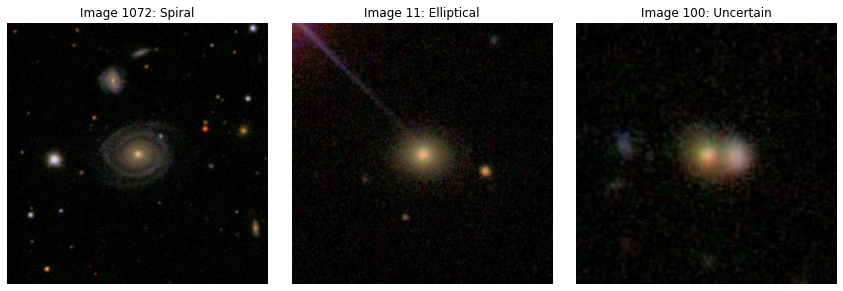

In [3]:
# Loading in example images
image1 = mpimg.imread("C:/Users/vince/Downloads/images_gz2/images/1072.jpg")
image2 = mpimg.imread("C:/Users/vince/Downloads/images_gz2/images/11.jpg")
image3 = mpimg.imread("C:/Users/vince/Downloads/images_gz2/images/100.jpg")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns

# plotting images
axes[0].imshow(image1)
axes[0].axis('off')
axes[0].set_title('Image 1072: Spiral')

axes[1].imshow(image2)
axes[1].axis('off')
axes[1].set_title('Image 11: Elliptical')

axes[2].imshow(image3)
axes[2].axis('off')
axes[2].set_title('Image 100: Uncertain')

plt.tight_layout()
plt.show()

<h3 align="center">Classes</h3>
<b>Spirals: </b> The first image shows a typical spiral galaxy where we can see two faint spiral arms coming out of the central bulge. Notably, some of the other galaxies have less distinct spiral arms so these are likely to be misclassified most often. In addition, the central brightness profile of the spiral disk is typically modelled as an elliptical because of their similar shape. Another consideration is that some spiral galaxies can be viewed 'edge-on' (like looking at a plate at eye level) - in this case, we might mis-classify a spiral galaxy as an elliptical; however, this cannot be resolved unless we look more in-depth at the stellar populations, age, and chemical composition. 

<b>Ellipticals: </b> In the second image, we lose the spiral arm pattern and instead see a fluffy cloud of gas that resmbeled the disk of this galaxy. The overall brightness profile here roughly resembles the profile seen in the spiral galaxy image, so there may be some issues between classifying between the two.

<b>Uncertain: </b> In the third image, we have two sources of central brightness in contrast to the first two images - this is clearly an outlier since we lack the smoothness of the elliptical galaxy and the pattern of the spiral galaxies. In astronomy, a combination of color (in optical observations) and spectrometry can be used to identiy the chemical signature of sources. Because the two sources of light in this image are quite different in color, the most likely explanation is that these are two different galaxies merging. 

<h3 align="center">Notes</h3>
<b>Background galaxies: </b> We can also see varying numbers of background galaxies in each image which may become an issue when classifying them if the classification picks up a lot of background data. I will choose to ignore this until if/when it becomes an issue. 

<b>Light Aberration: </b> In the second image, we can see a source in the upper left corner that sheds a bright light towards the center which may hinder classification accuracy. There is also the possibility that it is picked up as another galaxy if bright enough. 

<b>Uncertain classification: </b> This class simply contains eveyrthing that did not reach an $80\%$ vote threshold for spiral or ellitpical; therefore, there are not consistent features across each image in this class which may make classification difficult. It is likely that these will be classified incorrectly more often because they still have structural features that ressemble the spiral and/or ellitpical class. 

<h3 align="center">Part 2: Preprocessing Data</h3>
<hr style="height:2px; background-color: black;">

<b> Loading in images: </b> Loading in our image data from our target file. The images loaded in are named with their classification contained in a csv. Because the questions used for classification in Galaxy Zoo do not depend on the intrinsic color of images, I flatten the images into greyscale images for ease of use. 

In [4]:
# Use glob to find all image filenames matching the pattern
image_files = glob.glob(os.path.join("C:/Users/vince/Downloads/images_gz2/images/",'*.jpg'))

# Load images using cv2.imread and convert them to grayscale
X = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in image_files]

In [5]:
# Need to remove nan values from image
X_clean = [np.nan_to_num(image) for image in X]

# convert to array
X = [np.array(image) for image in X_clean]

# flatten images (needed for ML methods used)
#X = X.reshape(len(X), -1)

In [6]:
# we also need the filename, without the entire path and .jpg
filenames = [int(os.path.splitext(os.path.basename(file))[0]) for file in image_files]
# this gives us the 'asset_id' of each image which corresponds to the source OBJID

<b> Loading in csv data: </b> Getting the image classification data and image ID from two CSVs and merging them on the image id column. Now that we have the asset_id of each image in our sample, we can also get the OBJID from the filename_mapping.csv. Next, we can get the classification from the Gal_zoo.csv data. 

In [7]:
# get asset_id and OBJID of each galaxy
ID = pd.read_csv("C:/Users/vince/Downloads/gz2_filename_mapping.csv")
ID.rename(columns = {'objid':'OBJID'}, inplace = True)

# use OBJID to get classification of each galaxy 
gal = pd.read_csv("C:/Users/vince/Downloads/GalaxyZoo1_DR_table2.csv (1)/GalaxyZoo1_DR_table2.csv")

# merge data on the OBJID 
merged_data = pd.merge(ID, gal, on = 'OBJID', how = 'right')

# removing objects that dont have an asset_id available
data_nonan = merged_data.dropna()

# this step makes sure the order of images matches the labels order 
# ordered the files in ascneding order to ensure they matched up
data_nonan = data_nonan.sort_values(by='asset_id')

In [8]:
# putting asset id in df will allow us to merge on asset_id
asset_id = pd.DataFrame({'asset_id':filenames})

# merging on asset_id 
data_m = pd.merge(data_nonan, asset_id, on = 'asset_id', how = 'right')
print(data_m)

              OBJID    sample  asset_id           RA          DEC  NVOTE  \
0      5.877230e+17  original     100.0  13:13:28.44  -01:12:40.4   36.0   
1      5.877230e+17  original    1000.0  12:42:40.03  +00:09:25.9   25.0   
2      5.877256e+17  original   10000.0  07:56:47.62  +45:52:40.2   35.0   
3      5.877369e+17  original  100000.0  14:13:19.32  +12:44:23.9   34.0   
4      5.877369e+17  original  100001.0  14:13:52.43  +12:41:48.3   20.0   
...             ...       ...       ...          ...          ...    ...   
14055  5.877389e+17  original  115401.0  08:40:28.54  +25:39:43.1   60.0   
14056  5.877389e+17  original  115402.0  08:41:44.25  +25:50:40.6   22.0   
14057  5.877389e+17  original  115403.0  08:41:40.57  +25:48:28.0   56.0   
14058  5.877389e+17  original  115404.0  08:42:45.05  +25:55:23.2   40.0   
14059  5.877389e+17  original  115405.0  08:44:33.71  +26:07:01.2   40.0   

        P_EL   P_CW  P_ACW  P_EDGE   P_DK   P_MG   P_CS  P_EL_DEBIASED  \
0      0.306 

As expected, we have a dataframe that has 14060 rows for each image in our sample along with a few other parameters describing the structure and classification of each image. Here is a brief description of each parameter in our dataframe: <br>
* <b>OBJID:</b> Object ID is just the name of the galaxy. Not all galaxies get a nice name, these are just a bunch of numbers.
* <b>sample:</b> Tells us what survey each galaxy came from.
* <b>asset_id:</b> This is the naming scheme for the images used for classification.
* <b>RA:</b> Right ascension coordinate (in units of hours, minutes, seconds)
* <b>DEC:</b> Declination coordinate (in units of hours, minutes, seconds)
* <b>NVOTE:</b> Total number of people that voted 
* <b>P_EL:</b> Proportion of votes for the ellitpical class
* <b>P_CW:</b> Proportion of votes for clockwise spiral class
* <b>P_ACW:</b> Proportion of votes for anticlockwise spiral class
* <b>P_edge:</b> Proportion of votes for an edge-on galaxy class
* <b>P_DK:</b> Proportion of votes that dont know the class
* <b>P_MG:</b> Proportion of votes for the merger class
* <b>P_CS:</b> Combined spiral (P_E + P_CW + P_ACW) proportion
* <b>P_EL_DEBIASED:</b> Debiased proportion of elliptical galaxies. This is used for the final classification
* <b>P_CS_DEBIASED:</b> Debiased proportion of combined spiral galaxies. This is used for the final classification
* <b>SPIRAL:</b> Spiral if = 1 : An $\approx 80 \%$ vote threshold is used for determining the final class
* <b>ELLIPTICAL:</b> Elliptical if = 1
* <b>UNCERTAIN:</b> Uncertain if = 1






The next step in preprocessing will be putting the data in a workable format before trying a few image classification methods. All of the image are stored in grayscale_images, but we also need the classification stored in a list that matches the order of the images loaded in. This means that the 3 class columns in the dataframe need to be combined into a single labels list. 

In [9]:
# make a new df with just class
Y = data_m[['SPIRAL', 'ELLIPTICAL', 'UNCERTAIN']]

# Define a function to get the class name 
def get_class(row):
    if row['SPIRAL'] == 1:
        return 0
    elif row['ELLIPTICAL'] == 1:
        return 1
    elif row['UNCERTAIN'] == 1:
        return 2


# Apply the function to each row to create a new column
Y['Class'] = Y.apply(get_class, axis=1)

Y.drop(['SPIRAL', 'ELLIPTICAL', 'UNCERTAIN'], axis=1, inplace=True)
Y['Class'] = Y['Class'].fillna(2.0)

# turn into 1d array
y = Y['Class'].values.ravel()

C:\Users\vince\AppData\Local\Temp\ipykernel_18456\2626571225.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Class'] = Y.apply(get_class, axis=1)
C:\Users\vince\AppData\Local\Temp\ipykernel_18456\2626571225.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y.drop(['SPIRAL', 'ELLIPTICAL', 'UNCERTAIN'], axis=1, inplace=True)
C:\Users\vince\AppData\Local\Temp\ipykernel_18456\2626571225.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

Now we have our X and Y data for developing an image classification model. 
* <b>X:</b> These are the grayscale images in 2D arrays 
* <b>Y:</b> These are the labels represented with a binary representation for each class. 0 = False, 1 = True

<h3 align="center">Part 3: Methods</h3>
<hr style="height:2px; background-color: black;">
<h3 align="center">Train/ Test Split</h3>
The first step in training any supervised machine learning model is performing a train/test split on our data so our model has something to train on before trying to label the test data. There is no exact split, but we can try several splits to see which one has the best performance metrics while testing on as much data as possible. I will use a single train/tets split and look at different fractions to see how results vary for each method

In [9]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=936)

* test_size is the fraction of data that will be tested on, so the train_size will be 1 - test_size. 
* Specifying a random state will allow the results to be reproducible

<h3 align="center">Method 1: K-Nearest Neighbors (KNN)</h3>


Classification Report:

               precision    recall  f1-score   support

         0.0       0.76      0.34      0.47      1408
         1.0       0.62      0.03      0.06       585
         2.0       0.58      0.93      0.72      2225

    accuracy                           0.61      4218
   macro avg       0.65      0.43      0.42      4218
weighted avg       0.65      0.61      0.54      4218


Confusion Matrix:



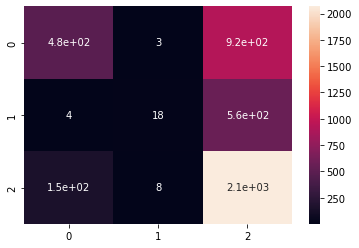

In [10]:
# Create a K-Nearest Neighbors classifier
knn_classifier = KNeighborsClassifier(n_neighbors=15)

# flatten images into a vector
X_train_knn = [np.ravel(image) for image in X_train]
X_test_knn = [np.ravel(image) for image in X_test]

# Train the classifier
knn_classifier.fit(X_train_knn, y_train)

# Predict the labels for test set
y_pred_knn = knn_classifier.predict(X_test_knn)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(y_test, y_pred_knn))
print('\nConfusion Matrix:\n')

sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot = True)
plt.show()

<h3 align="center">Method 2: Gaussian Naive Bayes Classifier (GNB)</h3>


Classification Report:

               precision    recall  f1-score   support

         0.0       0.39      0.73      0.51      1408
         1.0       0.22      0.20      0.21       585
         2.0       0.61      0.30      0.40      2225

    accuracy                           0.43      4218
   macro avg       0.41      0.41      0.37      4218
weighted avg       0.48      0.43      0.41      4218


Confusion Matrix:



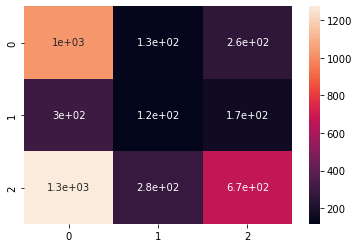

In [11]:
# Create a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# flatten images into a vector
X_train_nb = [np.ravel(image) for image in X_train]
X_test_nb = [np.ravel(image) for image in X_test]

# Train the classifier
nb_classifier.fit(X_train_nb, y_train)

# Predict the labels for test set
y_pred_nb = nb_classifier.predict(X_test_nb)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(y_test, y_pred_nb))
print('\nConfusion Matrix:\n')

sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot = True)
plt.show()

<h3 align="center">Method 3: Random Forests</h3>


Classification Report:

               precision    recall  f1-score   support

         0.0       0.72      0.64      0.68      1408
         1.0       0.71      0.15      0.25       585
         2.0       0.65      0.83      0.73      2225

    accuracy                           0.67      4218
   macro avg       0.69      0.54      0.55      4218
weighted avg       0.68      0.67      0.64      4218


Confusion Matrix:



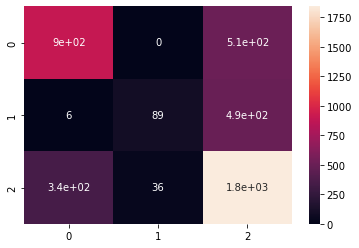

In [12]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# flatten images into a vector
X_train_rf = [np.ravel(image) for image in X_train]
X_test_rf = [np.ravel(image) for image in X_test]

# Train the classifier
rf_classifier.fit(X_train_rf, y_train)

# Predict on the training set
y_train_pred = rf_classifier.predict(X_train_rf)

# Predict on the test set
y_test_pred = rf_classifier.predict(X_test_rf)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(y_test, y_test_pred))
print('\nConfusion Matrix:\n')

sns.heatmap(confusion_matrix(y_test, y_test_pred), annot = True)
plt.show()

<h3 align="center">Method 4: Tuned Random Forest:</h3>

From the initial methods used, we achieved accuracy measures of 0.61, 0.43, and 0.67. Clearly, the random forest outperforms the other two methods significantly. I also tuned the k hyperparameter for KNN, which did not improve the results - the maximum accuracy was found to be 0.61 for a k of 15 which is shown in the previous example. 

For improving the accuracy of the model, we can implement two additional steps that may improve our model's training. One of these is tuning hyperparameters so that we can achieve the optimal hyperparameters for the images. Another is data augmentation, which is used for generating additional data for training the model. Data augmentation can be useful when a sample is small, which can prove especially helpful since the elliptical galaxies are undersampled. 

In [45]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Augmentation for training data
# does random stuff to images to generate new data
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontally flips images
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),  # random Gaussian blur
    iaa.ContrastNormalization((0.75, 1.5)),  # contrast normalization
    iaa.Multiply((0.8, 1.2), per_channel=0.2),  # random brightness
    iaa.Affine(rotate=(-10, 10))  # random rotation
], random_order=True)  # apply augmentations in random order

augmented_images = []
augmented_labels = []
for image, label in zip(X_train, y_train):
    augmented_image = seq(image=image)
    augmented_images.append(augmented_image)
    augmented_labels.append(label)

# Concatenate augmented training data with original training data
X_train_combined = np.concatenate((X_train, augmented_images), axis=0)
y_train_combined = np.concatenate((y_train, augmented_labels), axis=0)  

In [2]:
X_train_combined = [np.ravel(image) for image in X_train_combined]
# Train the classifier with the augmented data
best_rf = RandomForestClassifier(n_estimators = 100, random_state=369369)
best_rf.fit(X_train_combined, y_train_combined)

NameError: name 'X_train_combined' is not defined

performing on test data

Classification Report:

               precision    recall  f1-score   support

         0.0       0.65      0.66      0.66       856
         1.0       0.68      0.24      0.35       417
         2.0       0.67      0.78      0.72      1539

    accuracy                           0.66      2812
   macro avg       0.67      0.56      0.57      2812
weighted avg       0.66      0.66      0.64      2812


Confusion Matrix:



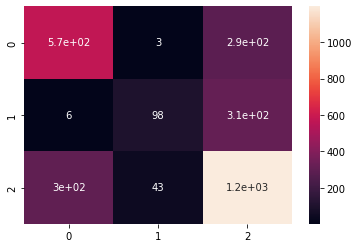

In [50]:
X_test_flat = [np.ravel(image) for image in X_test]

print("performing on test data")
# Predict on the test set
y_pred = best_rf.predict(X_test_flat)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(y_test, y_pred))
print('\nConfusion Matrix:\n')

sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)
plt.show()

As we can see the accuracy reminaed roughy the same, actually a slight decrease to 0.66, so the data augmentation method did not perform as expected. One more method I will try is an XGBoost classifer with tuned hyperparameters that should help better train the data and hopefully achieve higher accuracy.

In [12]:
# tuned XGBoost 
#xgb = XGBClassifier(n_jobs = -1, seed = 69)
parameters = {'max_depth': 4, 
              'tree_method': 'approx',
              'reg_lambda': 1,
             }

# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)
model_tuned = xgb.XGBClassifier(**parameters)

In [15]:
# flatten images
X_test = [np.ravel(image) for image in X_test]
X_train = [np.ravel(image) for image in X_train]

In [ ]:
# fit training
model_tuned.fit(X_train, y_train)
ypred_xgb = model_tuned.predict(X_train)

In [ ]:
# predict test
ypred_xgb_test = model_tuned.predict(X_test)

# results
print('\nTesting Classification Report:\n\n', classification_report(y_test, ypred_xgb_test))
print('\nTesting Confusion Matrix:\n')
sns.heatmap(confusion_matrix(y_test, ypred_xgb_test))
plt.show()

Unfortunately, I was unable to get this section working and kept getting weird errors about memory loss and my computer kept crashing. Sorry.

<h3 align="center">Part 4: Analysis</h3>
<hr style="height:2px; background-color: black;">

<b>Overall:</b> <br>
Taking a look at the initial resulting confusion matrices across all four methods, we can see there are quite a few discrepancies and different methods mis-classified different classifications. In general, the elliptical classification was the worst classification out of the three, while the spiral class performed the best - this makes sense because the spirals are typically well-defined and stand out the most out of the visual features. We can also see that when the elliptical galaxies are misclassified, they are often classified as uncertain instead. Due to the Malmquist Bias, the overall number of ellitpical galaxies are limited compared to the spiral galaxies sampled; therefore, the mis classification may be due to having a smaller sample of elliptical galaxies to train the data on. 

<b>Final Results:</b><br>
With the addition of data augmentation the results remained roughly the same at an accuracy of 0.66, which suggests the quantity of images is not an issue, but perhaps the quality needs to be considered. In particular, many of the images contain overlapping galaxies, merging galaxies, and background galaxies - which likely caused the model to misclassify many galaxies. Another method attempted was the XGBoost method which may achieve better accuracy with the addition of the hyperparameter tuning step added. In this project, the most effective model was found through using a random forest for image classification, achieving an accuracy metric of 0.67.

<h3 align="center">Sources</h3>
<hr style="height:2px; background-color: black;">

Galaxy Zoo Data: https://data.galaxyzoo.org/